## Test the use of a pre-trained transformer model for text classification

### Load libraries

In [192]:
# Data wrangling
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from pyprojroot.here import here

# Model training
import torch
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm.auto import tqdm
from datasets import load_metric

# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

### Preprocess data

In [193]:
# Load the training data and combine
data_path = here("data/training_data")
all_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith(".csv")]
df_list = [pd.read_csv(file) for file in all_files]
combined_df = pd.concat(df_list, ignore_index=True)

# Load the excel file containing category information
category_info = pd.read_excel(here("data/All_Updated_Categories_2019_edited_by_mikkel.xlsx"))

# Merge the dataframes
merged_df = pd.merge(
  combined_df, 
  category_info, 
  left_on = "SubType", 
  right_on = "subcategory",
  how = "left"
)

### Quality control

In [190]:
# Check the number of documents for each class, category, and subcategory
class_counts = merged_df['class'].value_counts()
subcategory_counts = merged_df['subcategory'].value_counts()

print("Class Counts:\n", class_counts)
print("\nSubcategory Counts:\n", subcategory_counts)

Class Counts:
 class
Infectious_Disease    27508
Other                 11514
Autoimm               11167
Cancer                10957
Allergen               4019
Transplant             1805
Name: count, dtype: int64

Subcategory Counts:
 subcategory
OTC       2885
OTFLU     2534
OTGA      2479
PLASMO    2183
SARS      2175
          ... 
FIB         23
METAL       23
BIME        20
INTG        17
PROST       16
Name: count, Length: 176, dtype: int64


In [49]:
missing_values = merged_df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 PubMed_ID           0
Title               8
Abstract            0
SubType             0
Class             487
Category        16265
Subcategory       487
Abbreviation      487
OK                487
class             487
category        16265
subcategory       487
dtype: int64


In [50]:
# Look at the papers with missing titles
merged_df[merged_df.Title.isnull()]

,PubMed_ID,Title,Abstract,SubType,Class,Category,Subcategory,Abbreviation,OK,class,category,subcategory
5459,11006009,NaN,[Data extracted from this article was imported...,HCV,Infectious Disease,ssRNA (+) Strand Virus,Hepatitis C Virus,HCV,x,Infectious_Disease,ssRNA_positive,HCV
10499,8567982,NaN,[Data extracted from this article was imported...,HBV,Infectious Disease,Retro-Transcribing Virus,Hepatitis B Virus,HBV,x,Infectious_Disease,Retro-Transcribing_Virus,HBV
13215,11012976,NaN,[Data extracted from this article was imported...,OTFLU,Infectious Disease,ssRNA (-) Strand Virus,Other Influenza A Subtypes,OTFLU,x,Infectious_Disease,ssRNA_negative,OTFLU
16750,11426965,NaN,[Data extracted from this article was imported...,HPV,Infectious Disease,dsDNA Virus,Human papillomavirus,HPV,x,Infectious_Disease,dsDNA_Virus,HPV
24876,15585860,NaN,Structural and physiological facets of carbohy...,MOAB,Other,Peptidic Antigen,General Monoclonal Antibodies,MOAB,x,Other,Peptidic_Antigen,MOAB
44549,15001714,NaN,CD8 T lymphocytes recognize peptides of 8 to 1...,MAA,Cancer,NaN,"Tyrosinase, TRP2, GP100, TRP1, MART1, SOX10 (M...",MAA,x,Cancer,NaN,MAA
54471,29572442,NaN,The B cell survival factor (TNFSF13B/BAFF) is ...,OTLUP,Autoimmune,Lupus,Other,OTLUP,x,Autoimm,Lupus,OTLUP
63300,14724640,NaN,Cytotoxic T lymphocytes (CTLs) detect and dest...,RENAL,Cancer,NaN,Renal (RCC),RENAL,x,Cancer,NaN,RENAL


It seems like there are some of the abstract there are not extracted correctly.
They all starts with "[Data extracted from this article was imported...".

In [51]:
# Create a boolean mask for rows where the abstract starts with the specified string
mask = merged_df['Abstract'].str.startswith("[Data extracted from this article was imported")

# Filter out these rows
filtered_df = merged_df[~mask]

# Check the number of rows before and after filtering
print(f"Number of rows before filtering: {len(merged_df)}")
print(f"Number of rows after filtering: {len(filtered_df)}")
print(f"Difference: {len(merged_df) - len(filtered_df)}")


Number of rows before filtering: 67457
Number of rows after filtering: 67403
Difference: 54


In [52]:
missing_values = filtered_df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 PubMed_ID           0
Title               4
Abstract            0
SubType             0
Class             487
Category        16265
Subcategory       487
Abbreviation      487
OK                487
class             487
category        16265
subcategory       487
dtype: int64


In [179]:
### Split the Data for the class variable
target = "subcategory"

# Drop rows where 'class' is NA
filtered_df = filtered_df.dropna(subset=[target])

# Check the number of rows after dropping
print(f"Number of rows after dropping NAs in target: {len(filtered_df)}")

# Split the data into train and a temporary dataset (70% train, 30% temp)
train_df, temp_df = train_test_split(filtered_df, test_size=0.3, random_state=42, stratify=filtered_df[target])

# Split the temporary dataset into validation and test datasets (50% validation, 50% test from the temp dataset)
eval_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df[target])

# Initialize the label encoder
label_encoder = LabelEncoder()

# Transform class label from string to integers
# Fit the encoder on the 'class' column and transform it
train_df['target_int'] = label_encoder.fit_transform(train_df[target])
eval_df['target_int'] = label_encoder.transform(eval_df[target])
test_df['target_int'] = label_encoder.transform(test_df[target])


# Check the number of rows in each dataset
print(f"Number of rows in train dataset: {len(train_df)}")
print(f"Number of rows in validation dataset: {len(eval_df)}")
print(f"Number of rows in test dataset: {len(test_df)}")

Number of rows after dropping NAs in target: 66916
Number of rows in train dataset: 46841
Number of rows in validation dataset: 10037
Number of rows in test dataset: 10038


In [182]:
# Check the number of documents from each class in the train dataset
train_class_counts = train_df[target].value_counts()

# Check the number of documents from each class in the validation dataset
valid_class_counts = eval_df[target].value_counts()

# Check the number of documents from each class in the test dataset
test_class_counts = test_df[target].value_counts()

print("Number of documents from each class in train dataset:\n", train_class_counts)
print("\nNumber of documents from each class in validation dataset:\n", valid_class_counts)
print("\nNumber of documents from each class in test dataset:\n", test_class_counts)

Number of documents from each class in train dataset:
 subcategory
OTC       2019
OTFLU     1763
OTGA      1735
PLASMO    1528
SARS      1522
          ... 
FIB         16
METAL       16
BIME        14
INTG        12
PROST       11
Name: count, Length: 176, dtype: int64

Number of documents from each class in validation dataset:
 subcategory
OTC       433
OTFLU     378
OTGA      372
PLASMO    327
SARS      326
         ... 
LAT         4
LIPO        4
BIME        3
INTG        3
PROST       3
Name: count, Length: 176, dtype: int64

Number of documents from each class in test dataset:
 subcategory
OTC       433
OTFLU     378
OTGA      372
PLASMO    328
SARS      327
         ... 
LIPO        3
FIB         3
BIME        3
PROST       2
INTG        2
Name: count, Length: 176, dtype: int64


### Fine-tune the BioBert transformer model

In [183]:
# Load BioBERT and tokenizer
model_name = "dmis-lab/biobert-base-cased-v1.2"
tokenizer = BertTokenizer.from_pretrained(model_name)
num_labels = len(train_df['target_int'].unique())
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# 1. Tokenization
data_size = 1000
train_abstract = train_df['Abstract'].tolist()[1:data_size]
eval_abstract = eval_df['Abstract'].tolist()[1:data_size]
tokenized_train = tokenizer(train_abstract, padding=True, truncation=True, return_tensors="pt", max_length=512)
tokenized_eval = tokenizer(eval_abstract, padding=True, truncation=True, return_tensors="pt", max_length=512)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [184]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


# Convert tokenized data to PyTorch dataset
train_labels = train_df['target_int'].tolist()[1:data_size]
eval_labels = eval_df["target_int"].tolist()[1:data_size]
train_dataset = CustomDataset(encodings = tokenized_train, labels = train_labels)
eval_dataset = CustomDataset(encodings = tokenized_eval, labels = eval_labels)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(eval_dataset, batch_size=8)


In [185]:
# 2. Training Loop
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

progress_bar = tqdm(range(num_training_steps))

model.train()

# For accumulating loss over the epoch
total_loss = 0.0

for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        # Add the batch loss to the total loss
        total_loss += loss.item()

        progress_bar.update(1)
        
        # Print loss for the current batch
        print(f"Batch Loss: {loss.item():.4f}")
    
    # Print average loss for the epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")
    
    # Reset total_loss for the next epoch
    total_loss = 0.0


  1%|          | 1/125 [00:09<18:43,  9.06s/it]

Batch Loss: 5.1829


  2%|▏         | 2/125 [00:18<18:29,  9.02s/it]

Batch Loss: 5.3590


  2%|▏         | 3/125 [00:26<18:02,  8.87s/it]

Batch Loss: 5.0713


  3%|▎         | 4/125 [00:35<17:55,  8.89s/it]

Batch Loss: 4.9489


  4%|▍         | 5/125 [00:44<17:46,  8.89s/it]

Batch Loss: 4.9329


  5%|▍         | 6/125 [00:53<17:22,  8.76s/it]

Batch Loss: 5.0485


  6%|▌         | 7/125 [01:01<17:03,  8.67s/it]

Batch Loss: 5.0527


  6%|▋         | 8/125 [01:10<16:53,  8.66s/it]

Batch Loss: 5.3141


  7%|▋         | 9/125 [01:18<16:38,  8.61s/it]

Batch Loss: 5.1371


  8%|▊         | 10/125 [01:27<16:43,  8.73s/it]

Batch Loss: 5.0218


  9%|▉         | 11/125 [01:36<16:26,  8.65s/it]

Batch Loss: 5.1175


 10%|▉         | 12/125 [01:44<16:13,  8.61s/it]

Batch Loss: 5.1344


 10%|█         | 13/125 [01:52<15:52,  8.51s/it]

Batch Loss: 5.2076


 11%|█         | 14/125 [02:01<15:46,  8.52s/it]

Batch Loss: 5.4158


 12%|█▏        | 15/125 [02:10<15:53,  8.67s/it]

Batch Loss: 5.4462


 13%|█▎        | 16/125 [02:19<16:04,  8.85s/it]

Batch Loss: 5.0402


 14%|█▎        | 17/125 [02:29<16:24,  9.11s/it]

Batch Loss: 5.2394


 14%|█▍        | 18/125 [02:38<16:15,  9.12s/it]

Batch Loss: 5.1719


 15%|█▌        | 19/125 [02:47<15:59,  9.05s/it]

Batch Loss: 5.2134


 16%|█▌        | 20/125 [02:55<15:31,  8.87s/it]

Batch Loss: 5.0747


 17%|█▋        | 21/125 [03:05<15:43,  9.07s/it]

Batch Loss: 5.2975


 18%|█▊        | 22/125 [03:13<15:06,  8.80s/it]

Batch Loss: 4.9528


 18%|█▊        | 23/125 [03:22<15:07,  8.89s/it]

Batch Loss: 4.9567


 19%|█▉        | 24/125 [03:32<15:28,  9.19s/it]

Batch Loss: 5.1889


 20%|██        | 25/125 [03:42<15:47,  9.48s/it]

Batch Loss: 5.0300


 21%|██        | 26/125 [03:52<15:39,  9.49s/it]

Batch Loss: 5.2917


 22%|██▏       | 27/125 [04:01<15:19,  9.38s/it]

Batch Loss: 4.8402


 22%|██▏       | 28/125 [04:10<15:14,  9.42s/it]

Batch Loss: 4.7998


 23%|██▎       | 29/125 [04:19<14:52,  9.30s/it]

Batch Loss: 5.1132


 24%|██▍       | 30/125 [04:28<14:29,  9.15s/it]

Batch Loss: 5.2376


 25%|██▍       | 31/125 [04:36<13:51,  8.85s/it]

Batch Loss: 5.1109


 26%|██▌       | 32/125 [04:45<13:45,  8.88s/it]

Batch Loss: 5.1973


 26%|██▋       | 33/125 [04:54<13:38,  8.90s/it]

Batch Loss: 5.1633


 27%|██▋       | 34/125 [05:03<13:31,  8.92s/it]

Batch Loss: 4.4491


 28%|██▊       | 35/125 [05:12<13:23,  8.93s/it]

Batch Loss: 4.8649


 29%|██▉       | 36/125 [05:21<12:58,  8.75s/it]

Batch Loss: 4.6777


 30%|██▉       | 37/125 [05:29<12:39,  8.63s/it]

Batch Loss: 5.1315


 30%|███       | 38/125 [05:37<12:21,  8.52s/it]

Batch Loss: 5.2536


 31%|███       | 39/125 [05:46<12:12,  8.52s/it]

Batch Loss: 5.2230


 32%|███▏      | 40/125 [05:54<11:59,  8.46s/it]

Batch Loss: 4.6620


 33%|███▎      | 41/125 [06:03<11:59,  8.57s/it]

Batch Loss: 5.1752


 34%|███▎      | 42/125 [06:12<11:56,  8.63s/it]

Batch Loss: 4.9854


 34%|███▍      | 43/125 [06:20<11:36,  8.50s/it]

Batch Loss: 4.8646


 35%|███▌      | 44/125 [06:28<11:25,  8.47s/it]

Batch Loss: 4.9089


 36%|███▌      | 45/125 [06:37<11:12,  8.41s/it]

Batch Loss: 5.1733


 37%|███▋      | 46/125 [06:45<11:16,  8.56s/it]

Batch Loss: 4.8193


 38%|███▊      | 47/125 [06:54<10:57,  8.43s/it]

Batch Loss: 4.5264


 38%|███▊      | 48/125 [07:02<10:54,  8.51s/it]

Batch Loss: 4.9672


 39%|███▉      | 49/125 [07:10<10:41,  8.44s/it]

Batch Loss: 4.8835


 40%|████      | 50/125 [07:19<10:38,  8.51s/it]

Batch Loss: 4.7393


 41%|████      | 51/125 [07:28<10:40,  8.66s/it]

Batch Loss: 4.8680


 42%|████▏     | 52/125 [07:38<10:47,  8.88s/it]

Batch Loss: 4.8098


 42%|████▏     | 53/125 [07:47<10:54,  9.09s/it]

Batch Loss: 4.8744


 43%|████▎     | 54/125 [07:55<10:26,  8.82s/it]

Batch Loss: 4.9611


 44%|████▍     | 55/125 [08:04<10:21,  8.88s/it]

Batch Loss: 4.9731


 45%|████▍     | 56/125 [08:13<10:09,  8.83s/it]

Batch Loss: 4.9741


 46%|████▌     | 57/125 [08:22<10:04,  8.88s/it]

Batch Loss: 5.0367


 46%|████▋     | 58/125 [08:30<09:42,  8.69s/it]

Batch Loss: 4.7784


 47%|████▋     | 59/125 [08:40<09:51,  8.96s/it]

Batch Loss: 4.9443


 48%|████▊     | 60/125 [08:49<09:46,  9.02s/it]

Batch Loss: 4.4703


 49%|████▉     | 61/125 [08:58<09:38,  9.04s/it]

Batch Loss: 4.6453


 50%|████▉     | 62/125 [09:06<09:13,  8.79s/it]

Batch Loss: 4.8929


 50%|█████     | 63/125 [09:15<08:55,  8.64s/it]

Batch Loss: 4.6412


 51%|█████     | 64/125 [09:24<08:57,  8.81s/it]

Batch Loss: 5.0860


 52%|█████▏    | 65/125 [09:32<08:42,  8.71s/it]

Batch Loss: 4.5580


 53%|█████▎    | 66/125 [09:41<08:28,  8.62s/it]

Batch Loss: 4.9419


 54%|█████▎    | 67/125 [09:49<08:21,  8.64s/it]

Batch Loss: 4.9244


 54%|█████▍    | 68/125 [09:58<08:05,  8.51s/it]

Batch Loss: 4.5459


 55%|█████▌    | 69/125 [10:07<08:02,  8.61s/it]

Batch Loss: 4.5893


 56%|█████▌    | 70/125 [10:15<07:49,  8.53s/it]

Batch Loss: 5.0882


 57%|█████▋    | 71/125 [10:23<07:35,  8.43s/it]

Batch Loss: 5.0534


 58%|█████▊    | 72/125 [10:32<07:41,  8.71s/it]

Batch Loss: 4.6284


 58%|█████▊    | 73/125 [10:41<07:35,  8.76s/it]

Batch Loss: 4.2919


 59%|█████▉    | 74/125 [10:50<07:19,  8.62s/it]

Batch Loss: 4.7933


 60%|██████    | 75/125 [10:58<07:10,  8.61s/it]

Batch Loss: 4.6482


 61%|██████    | 76/125 [11:06<06:57,  8.51s/it]

Batch Loss: 4.7936


 62%|██████▏   | 77/125 [11:15<06:44,  8.42s/it]

Batch Loss: 5.1063


 62%|██████▏   | 78/125 [11:24<06:55,  8.83s/it]

Batch Loss: 4.6914


 63%|██████▎   | 79/125 [11:34<06:57,  9.07s/it]

Batch Loss: 4.8999


 64%|██████▍   | 80/125 [11:42<06:37,  8.83s/it]

Batch Loss: 5.1665


 65%|██████▍   | 81/125 [11:51<06:25,  8.76s/it]

Batch Loss: 5.1359


 66%|██████▌   | 82/125 [11:59<06:08,  8.57s/it]

Batch Loss: 4.6365


 66%|██████▋   | 83/125 [12:07<05:53,  8.42s/it]

Batch Loss: 5.5400


 67%|██████▋   | 84/125 [12:16<05:48,  8.50s/it]

Batch Loss: 4.8068


 68%|██████▊   | 85/125 [12:24<05:36,  8.42s/it]

Batch Loss: 5.0462


 69%|██████▉   | 86/125 [12:32<05:26,  8.38s/it]

Batch Loss: 4.6757


 70%|██████▉   | 87/125 [12:40<05:15,  8.30s/it]

Batch Loss: 4.5973


 70%|███████   | 88/125 [12:49<05:05,  8.25s/it]

Batch Loss: 4.5573


 71%|███████   | 89/125 [12:57<04:56,  8.23s/it]

Batch Loss: 5.0389


 72%|███████▏  | 90/125 [13:05<04:48,  8.24s/it]

Batch Loss: 5.0195


 73%|███████▎  | 91/125 [13:13<04:39,  8.23s/it]

Batch Loss: 4.5682


 74%|███████▎  | 92/125 [13:22<04:33,  8.29s/it]

Batch Loss: 5.0682


 74%|███████▍  | 93/125 [13:30<04:26,  8.34s/it]

Batch Loss: 4.7276


 75%|███████▌  | 94/125 [13:39<04:19,  8.37s/it]

Batch Loss: 4.6238


 76%|███████▌  | 95/125 [13:47<04:10,  8.35s/it]

Batch Loss: 4.2980


 77%|███████▋  | 96/125 [13:56<04:05,  8.47s/it]

Batch Loss: 4.9447


 78%|███████▊  | 97/125 [14:04<03:59,  8.56s/it]

Batch Loss: 4.5514


 78%|███████▊  | 98/125 [14:13<03:47,  8.42s/it]

Batch Loss: 5.2607


 79%|███████▉  | 99/125 [14:21<03:37,  8.36s/it]

Batch Loss: 4.9242


 80%|████████  | 100/125 [14:30<03:33,  8.52s/it]

Batch Loss: 5.0234


 81%|████████  | 101/125 [14:38<03:26,  8.59s/it]

Batch Loss: 4.3608


 82%|████████▏ | 102/125 [14:48<03:24,  8.90s/it]

Batch Loss: 4.9367


 82%|████████▏ | 103/125 [14:57<03:19,  9.08s/it]

Batch Loss: 4.5640


 83%|████████▎ | 104/125 [15:07<03:14,  9.26s/it]

Batch Loss: 4.5525


 84%|████████▍ | 105/125 [15:17<03:06,  9.35s/it]

Batch Loss: 4.9999


 85%|████████▍ | 106/125 [15:26<02:55,  9.21s/it]

Batch Loss: 4.9354


 86%|████████▌ | 107/125 [15:35<02:45,  9.18s/it]

Batch Loss: 4.6019


 86%|████████▋ | 108/125 [15:44<02:36,  9.23s/it]

Batch Loss: 4.7719


 87%|████████▋ | 109/125 [15:52<02:22,  8.90s/it]

Batch Loss: 4.4497


 88%|████████▊ | 110/125 [16:01<02:14,  8.96s/it]

Batch Loss: 4.7773


 89%|████████▉ | 111/125 [16:10<02:05,  8.97s/it]

Batch Loss: 5.1655


 90%|████████▉ | 112/125 [16:19<01:55,  8.88s/it]

Batch Loss: 4.8152


 90%|█████████ | 113/125 [16:28<01:45,  8.81s/it]

Batch Loss: 4.5392


 91%|█████████ | 114/125 [16:36<01:35,  8.66s/it]

Batch Loss: 4.5783


 92%|█████████▏| 115/125 [16:45<01:26,  8.68s/it]

Batch Loss: 4.7624


 93%|█████████▎| 116/125 [16:54<01:19,  8.80s/it]

Batch Loss: 4.8098


 94%|█████████▎| 117/125 [17:02<01:09,  8.71s/it]

Batch Loss: 4.6422


 94%|█████████▍| 118/125 [17:11<01:01,  8.73s/it]

Batch Loss: 4.4875


 95%|█████████▌| 119/125 [17:19<00:51,  8.62s/it]

Batch Loss: 4.5859


 96%|█████████▌| 120/125 [17:27<00:42,  8.46s/it]

Batch Loss: 4.6572


 97%|█████████▋| 121/125 [17:37<00:34,  8.65s/it]

Batch Loss: 5.1549


 98%|█████████▊| 122/125 [17:45<00:25,  8.49s/it]

Batch Loss: 5.0412


 98%|█████████▊| 123/125 [17:53<00:16,  8.42s/it]

Batch Loss: 4.2945


 99%|█████████▉| 124/125 [18:01<00:08,  8.42s/it]

Batch Loss: 4.9423


100%|██████████| 125/125 [18:08<00:00,  7.93s/it]

Batch Loss: 4.6066
Epoch 1 Average Loss: 4.8989


In [186]:
# 3. Evaluation
metric = load_metric("accuracy")

# Store probabilities, predictions and true labels
all_scores = []
all_predictions = []
all_true_labels = []

model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits

    # Get probabilities and predictions
    scores = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()

    # For computing the metric
    metric.add_batch(predictions=predictions, references=batch["labels"])

    # Save probabilites, predictions and labels
    all_scores.extend(scores)
    all_predictions.extend(predictions)
    all_true_labels.extend(batch["labels"].cpu().numpy())

print(metric.compute())

{'accuracy': 0.03003003003003003}


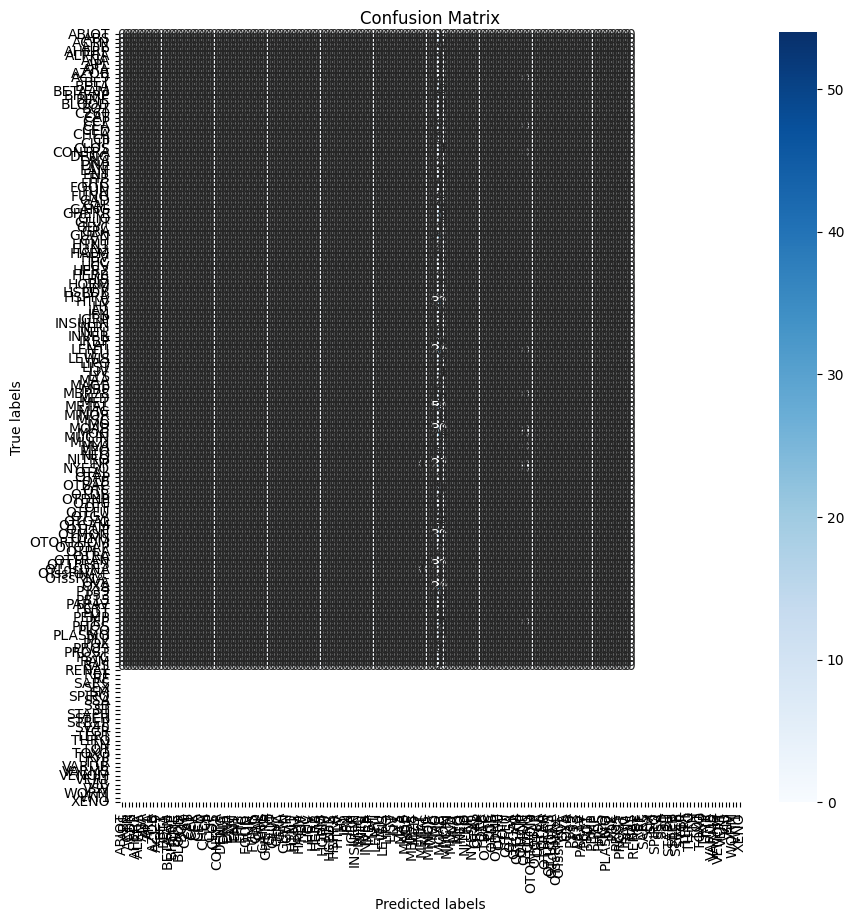

In [187]:
# Generate the confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig(here("results/biobert_fine_tune_1000_class_confusion_matrix.png"))
plt.show()


In [188]:
print(classification_report(all_true_labels, all_predictions, target_names=label_encoder.classes_))

ValueError: Number of classes, 145, does not match size of target_names, 176. Try specifying the labels parameter

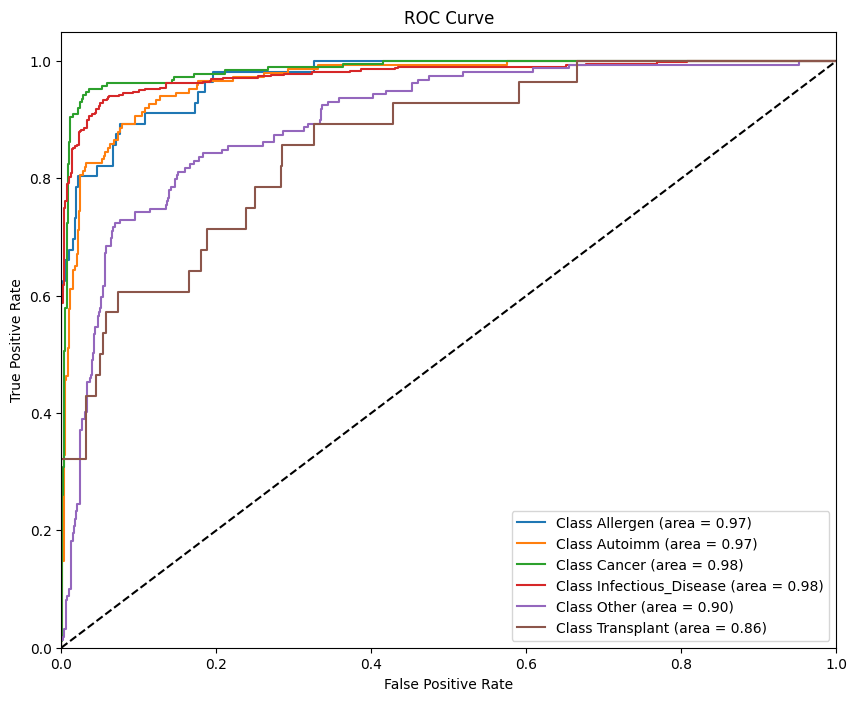

In [109]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the labels for multi-class ROC
true_labels_bin = label_binarize(all_true_labels, classes=np.arange(len(label_encoder.classes_)))

plt.figure(figsize=(10, 8))

# Compute ROC curve and ROC area for each class
for i in range(len(label_encoder.classes_)):
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], np.array(all_scores)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_encoder.classes_[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()



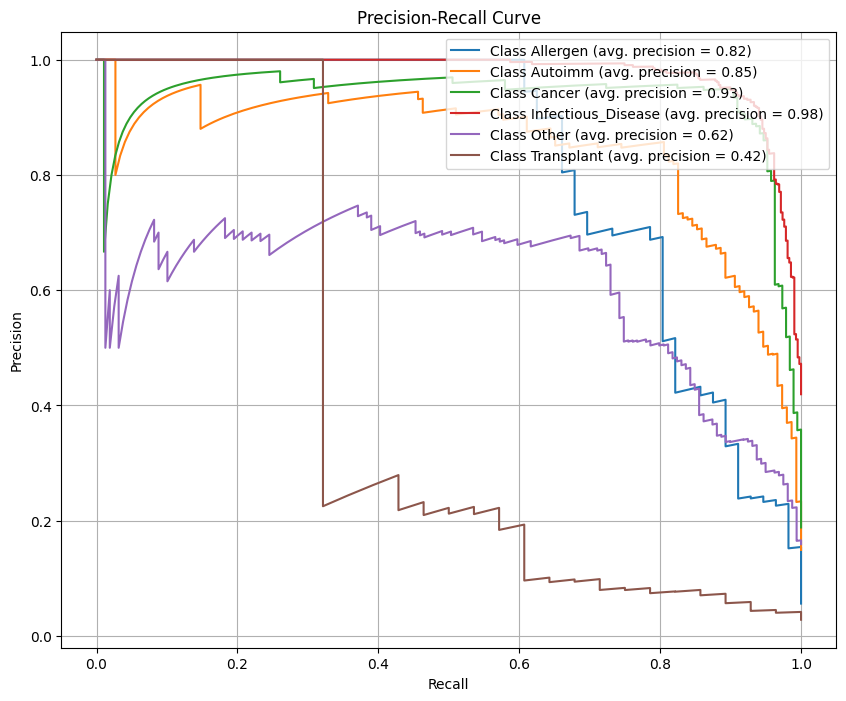

In [111]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 8))

# Compute Precision-Recall and plot curve for each class
for i in range(len(label_encoder.classes_)):
    precision, recall, _ = precision_recall_curve(true_labels_bin[:, i], np.array(all_scores)[:, i])
    avg_precision = average_precision_score(true_labels_bin[:, i], np.array(all_scores)[:, i])
    plt.plot(recall, precision, label=f'Class {label_encoder.classes_[i]} (avg. precision = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


In [114]:
from sklearn.metrics import roc_auc_score, average_precision_score

roc_aucs = []
pr_aucs = []

# Binarize the labels for multi-class AUC calculation
true_labels_bin = label_binarize(all_true_labels, classes=np.arange(len(label_encoder.classes_)))

# Calculate AUC for each class
for i in range(len(label_encoder.classes_)):
    roc_auc = roc_auc_score(true_labels_bin[:, i], np.array(all_scores)[:, i])
    pr_auc = average_precision_score(true_labels_bin[:, i], np.array(all_scores)[:, i])
    
    roc_aucs.append(roc_auc)
    pr_aucs.append(pr_auc)


# Create a DataFrame
df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'ROC AUC': roc_aucs,
    'PR AUC': pr_aucs
})

# Display the table
print(df)


                Class   ROC AUC    PR AUC
0            Allergen  0.970705  0.824171
1             Autoimm  0.967209  0.848195
2              Cancer  0.984751  0.932776
3  Infectious_Disease  0.977541  0.976640
4               Other  0.898899  0.615896
5          Transplant  0.857989  0.418492


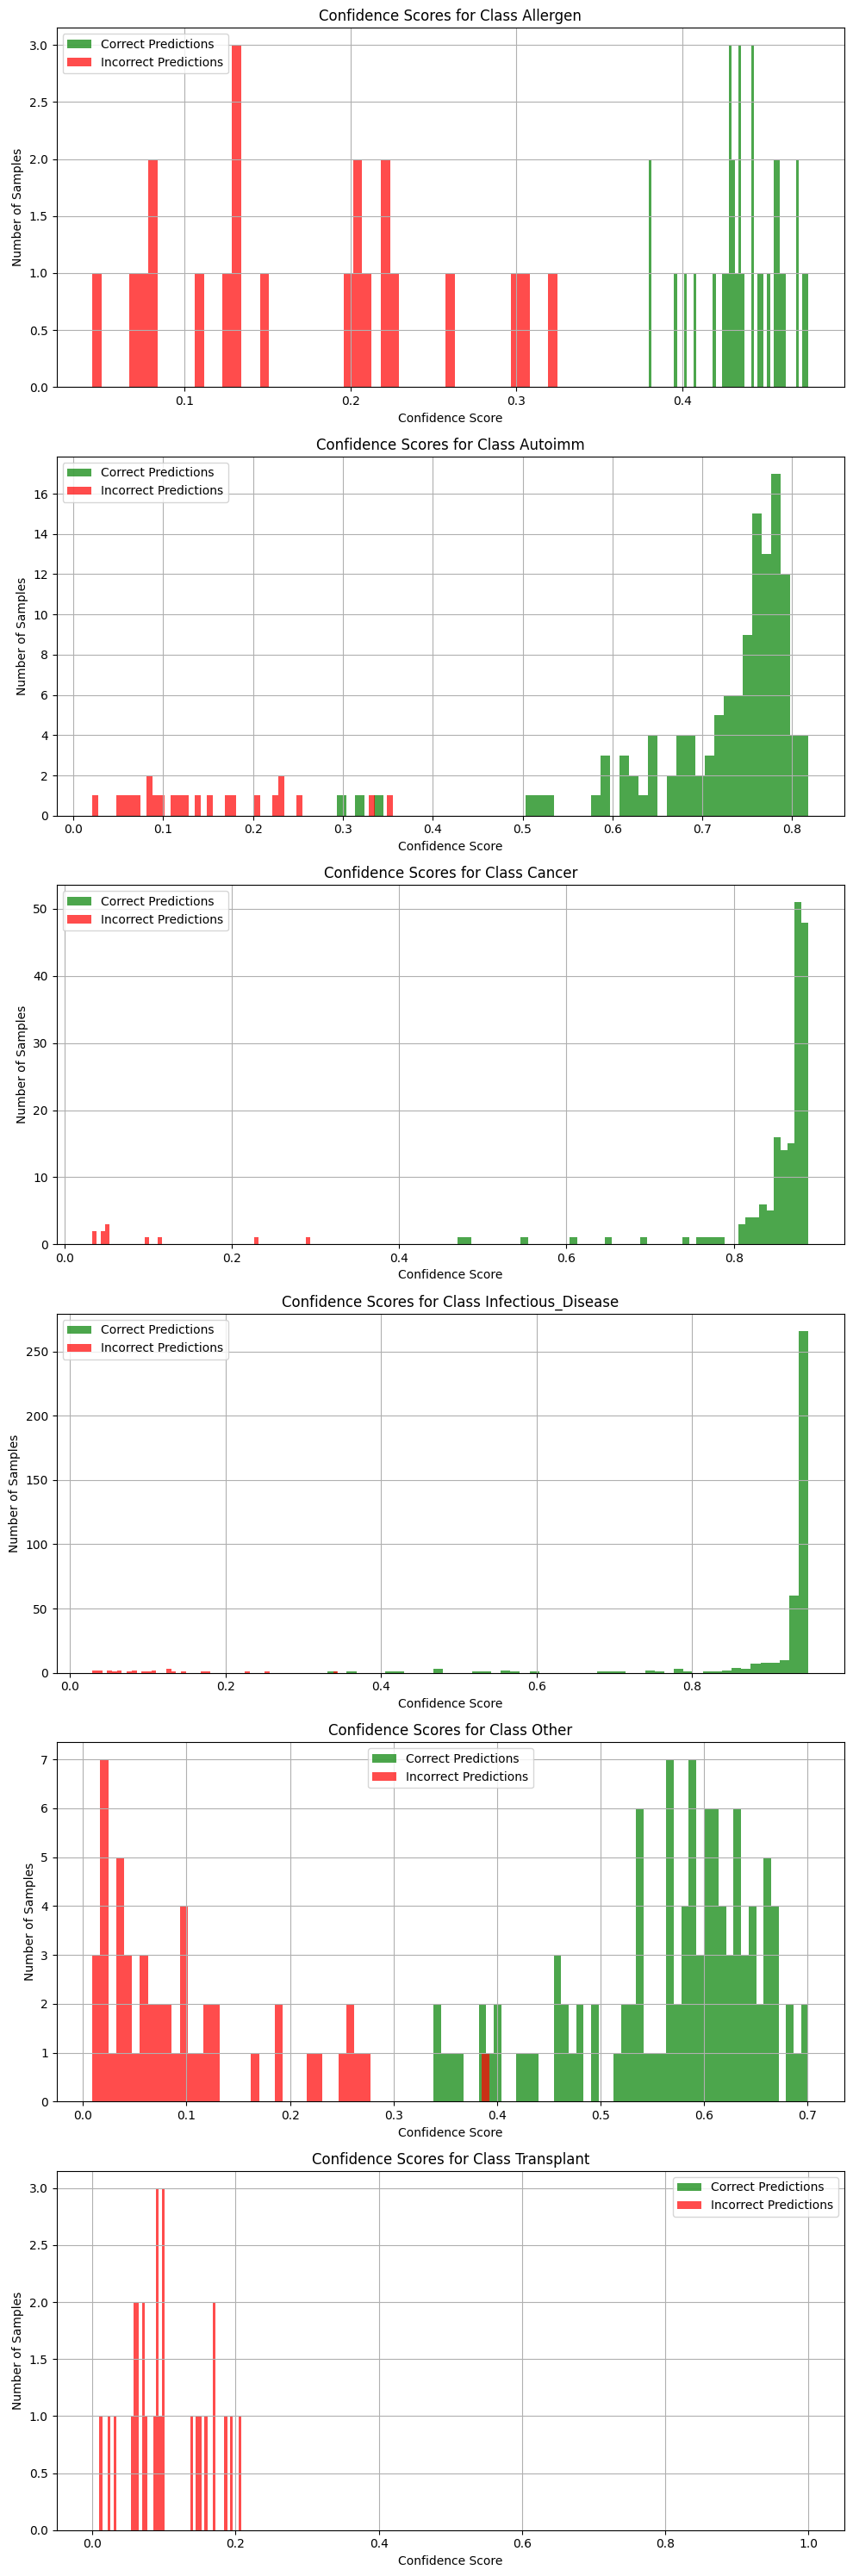

In [173]:
# Convert predictions and true labels to a numpy array for easier indexing
predicted_classes = np.array(all_predictions)
true_classes = np.array(all_true_labels)

# Number of classes
num_classes = len(label_encoder.classes_)

# Plot histograms for confidence scores of each class separately
fig, axes = plt.subplots(num_classes, 1, figsize=(10, 5 * num_classes))

for i in range(num_classes):
    # Correct predictions for this class
    correct_mask = (predicted_classes == i) & (true_classes == i)
    incorrect_mask = (predicted_classes != i) & (true_classes == i)
    
    axes[i].hist(all_scores_np[correct_mask, i], bins=50, color='green', alpha=0.7, label='Correct Predictions')
    axes[i].hist(all_scores_np[incorrect_mask, i], bins=50, color='red', alpha=0.7, label='Incorrect Predictions')
    
    axes[i].set_title(f'Confidence Scores for Class {label_encoder.classes_[i]}')
    axes[i].set_xlabel('Confidence Score')
    axes[i].set_ylabel('Number of Samples')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()
